In [1]:
# import agama
import arepo
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import matplotlib as mpl

from scipy.ndimage import gaussian_filter

from numba import njit

# agama.setUnits(mass=1E10, length=1, velocity=1)

In [2]:
@njit
def my_mult(mass, vel):
    out = np.zeros((len(mass), 3))
    for i in range(len(mass)):
        out[i][0] = mass[i] * vel[i][0] 
        out[i][1] = mass[i] * vel[i][1]
        out[i][2] = mass[i] * vel[i][2]
    return out

In [3]:
sim_list = ['Nbody', 'phantom-vacuum-Sg20-Rc3.5']

basepath = '/n/holystore01/LABS/hernquist_lab/Users/abeane/starbar_runs/runs/'

def read_snap(idx, sim_idx, lvl='lvl3', parttype=[0], fields=['Coordinates', 'Masses', 'Velocities', 'ParticleIDs', 'Potential'],
              basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output'
    return arepo.Snapshot(fname, idx, parttype=parttype, fields=fields, combineFiles=True)

def read_sfr(sim_idx, lvl='lvl3', basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output/sfr.txt'
    return np.genfromtxt(fname)

def read_fourier(sim_idx, lvl='lvl3', basepath='/n/home01/abeane/starbar/plots/'):
    sim = sim_list[sim_idx]
    f = h5.File(basepath+'/fourier_component/data/fourier_'+sim+'-'+lvl+'.hdf5', mode='r')
    return f

In [4]:
sn = read_snap(300, 1, 'lvl2', parttype=None, fields=None)

In [6]:
# base = '/n/home01/abeane/starbar/plots/bar_prop/data/'

# bar_prop_N = h5.File(base + 'bar_prop_Nbody-lvl3.hdf5', mode='r')
# bar_prop_S = h5.File(base + 'bar_prop_phantom-vacuum-Sg20-Rc3.5-lvl3.hdf5', mode='r')

In [7]:
sun_angle = 20. * (np.pi / 180.)
# bangle = bar_prop_S['bar_angle'][300] + sun_angle
bangle = 22. * (np.pi / 180.) + sun_angle

In [8]:
def rotate_pos(pos, ang):

    Rmat = np.array([[np.cos(ang), -np.sin(ang), 0.0],
                     [np.sin(ang),  np.cos(ang), 0.0],
                     [0.0,         0.0,          1.0]])
    
    pos = np.swapaxes(pos, 0, 1)
    pos = np.matmul(Rmat, pos)
    pos = np.swapaxes(pos, 0, 1)
    
    return pos

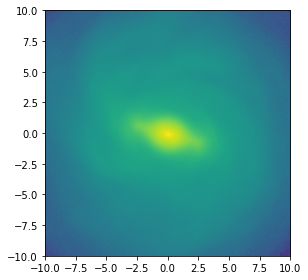

In [9]:
nres = 512

range_xy = [[-10, 10], [-10, 10]]
center = np.array([200., 200., 200.])

disk_pos = sn.part2.pos.value - center
disk_pos = rotate_pos(disk_pos, -bangle)

x = disk_pos[:,0]
y = disk_pos[:,1]
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1)

ax.imshow(heatmap_xy.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm())
ax.set_aspect('equal')
fig.tight_layout()

plt.show()


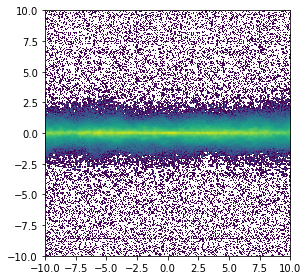

In [12]:
nres = 512

range_xy = [[-10, 10], [-10, 10]]
center = np.array([200., 200., 200.])

gas_pos = sn.part0.pos.value - center
gas_pos = rotate_pos(gas_pos, -bangle)

x = gas_pos[:,0]
y = gas_pos[:,2]
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy, weights=(1-sn.part0.MolecularHFrac)*sn.part0.mass.value)

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1)

ax.imshow(heatmap_xy.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm())
ax.set_aspect('equal')
fig.tight_layout()

plt.show()


In [11]:
import healpy as hp

ModuleNotFoundError: No module named 'healpy'

In [15]:
sun_pos = np.array([-8.2, 0.0, 0.0])

In [16]:
gas_pos = sn.part0.pos.value - center
gas_pos = rotate_pos(gas_pos, -bangle)

drvec = gas_pos - sun_pos

r = np.linalg.norm(drvec, axis=1)
theta = np.arccos(drvec[:,2]/r)
phi = np.arctan2(drvec[:,1], drvec[:,0])


In [ ]:
nside = 64

pix = hp.pixelfunc.ang2pix(nside, theta, phi)

In [ ]:
nside = 16
pix = hp.pixelfunc.ang2pix(nside, theta, phi)
npix = hp.pixelfunc.nside2npix(nside)
gas_plot = np.zeros(npix)
gas_plot[pix] += sn.part0.MolecularHFrac*sn.part0.mass.value / r**2

In [ ]:
gas_plot[gas_plot==0] = np.min(gas_plot)

In [ ]:
hp.mollview(gas_plot, norm='log', min=1E-09, max=1E-06)
plt.show()

In [ ]:
npix = hp.pixelfunc.nside2npix(nside)
gas_plot = np.zeros(npix)
gas_plot[pix] += (1-sn.part0.MolecularHFrac)*sn.part0.mass.value / r**2

In [ ]:
gas_plot[gas_plot==0] = np.min(gas_plot)

In [ ]:
hp.mollview(gas_plot, norm='log', min=1E-09, max=1E-06)
plt.show()

In [20]:
disk_x = sn.part2.pos.value - center
disk_v = sn.part2.vel.value

disk_dr = disk_x - sun_pos
disk_r = np.linalg.norm(disk_dr, axis=1)

vLSR = np.mean(disk_v[disk_r < 0.2], axis=0)
print(vLSR)

[  -2.0876443  -243.98615      -0.38128683]


In [21]:
gas_x = sn.part0.pos.value - center
gas_v = sn.part0.vel.value

gas_dr = gas_x - sun_pos
gas_r = np.linalg.norm(gas_dr, axis=1)
gas_rhat = my_mult(1./gas_r, gas_dr)

phi = np.arctan2(gas_dr[:,1], gas_dr[:,0])
theta = np.arccos(gas_dr[:,2]/gas_r)

gas_v = gas_v - vLSR

gas_vr = gas_rhat[:,0] * gas_v[:,0] + gas_rhat[:,1] * gas_v[:,1] + gas_rhat[:,2] * gas_v[:,2]

In [22]:
gas_v = sn.part0.vel.value

key = np.argmin(np.linalg.norm(gas_x, axis=1))
print(gas_rhat[key])
print(gas_vr[key])
print(gas_v[key])

[ 9.99999503e-01 -9.00457055e-05  9.93191496e-04]
-49.54687598934444
[ -51.630985  -115.959724     7.6435447]


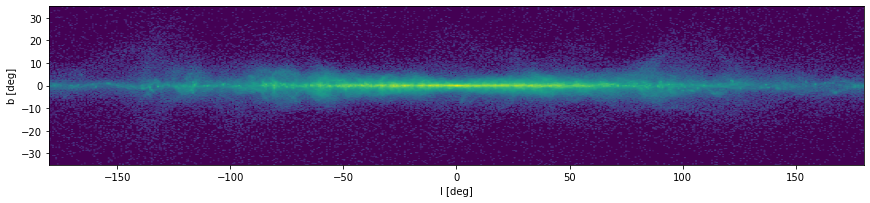

In [23]:
nres = 512

range_xy = [[-180, 180], [-35, 35]]

x = -phi * 180 / np.pi
y = (theta - np.pi/2.) * 180/np.pi
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy, weights=sn.part0.mass.value)

heatmap_xy[heatmap_xy==0.0] = np.min(heatmap_xy[heatmap_xy!=0.0])

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1, figsize=(12, 3))

ax.imshow(heatmap_xy.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm())
ax.set_aspect('equal')
fig.tight_layout()

ax.set(xlabel='l [deg]', ylabel='b [deg]')

plt.show()


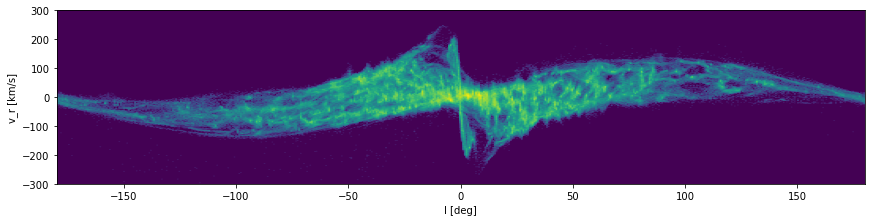

In [24]:
nres = 512

range_xy = [[-180, 180], [-300, 300]]

x = phi*180/np.pi
y = gas_vr
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)

heatmap_xy[heatmap_xy==0.0] = np.min(heatmap_xy[heatmap_xy!=0.0])

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1, figsize=(12, 3))

ax.imshow(heatmap_xy.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm())
ax.set_aspect('auto')
fig.tight_layout()

ax.set(xlabel='l [deg]', ylabel='v_r [km/s]')

plt.show()


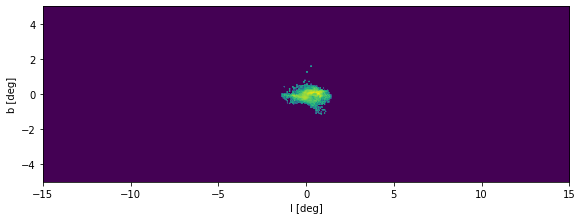

In [41]:
nres = 512

range_xy = [[-15, 15], [-5,5]]

x = -phi * 180 / np.pi
y = (theta - np.pi/2.) * 180/np.pi

gas_R = np.linalg.norm(gas_x[:,:2], axis=1)
key = gas_R < 0.2 

heatmap_xy, _, _ = np.histogram2d(x[key], y[key], bins=(nres, nres), range=range_xy, weights=sn.part0.MolecularHFrac[key]*sn.part0.mass.value[key])

heatmap_xy[heatmap_xy==0.0] = np.min(heatmap_xy[heatmap_xy!=0.0])

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.imshow(heatmap_xy.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm())
ax.set_aspect('equal')
fig.tight_layout()

ax.set(xlabel='l [deg]', ylabel='b [deg]')

plt.show()


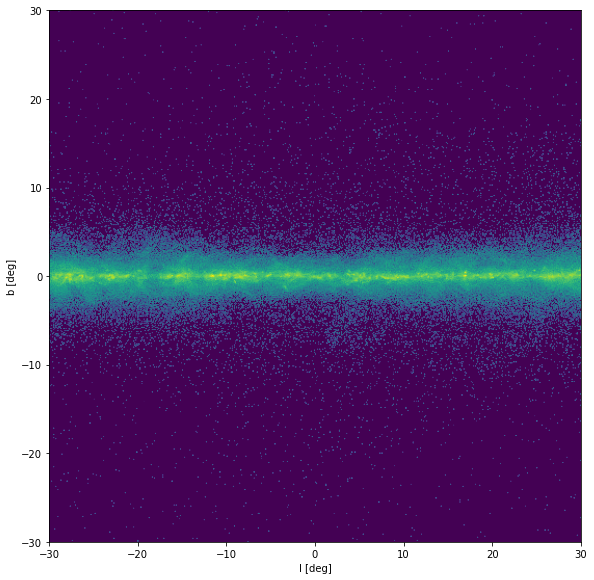

In [34]:
nres = 512

range_xy = [[-30, 30], [-30, 30]]

x = -phi * 180 / np.pi
y = (theta - np.pi/2.) * 180/np.pi

gas_R = np.linalg.norm(gas_x[:,:2], axis=1)
key = gas_R > 4

heatmap_xy, _, _ = np.histogram2d(x[key], y[key], bins=(nres, nres), range=range_xy, weights=sn.part0.mass.value[key])

heatmap_xy[heatmap_xy==0.0] = np.min(heatmap_xy[heatmap_xy!=0.0])

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.imshow(heatmap_xy.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm())
ax.set_aspect('equal')
fig.tight_layout()

ax.set(xlabel='l [deg]', ylabel='b [deg]')

plt.show()
